In [1]:
import sys
import os


sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("NonHermitianQW"))))

In [2]:
from operators import op
from oneDimQW import *
from twoDimQW import *
import numpy as np
from matplotlib import pyplot as plt
from numpy import pi
from numpy.linalg import eig
from scipy.linalg import expm
from berry import BerryPhase
from sympy import *
from ploting import berry_bloch_phase

In [3]:
import ipywidgets as widgets
from ipywidgets import interact

<h1>Non-unitary quantum walk</h1>

We are choosing the single-step quantum walk as a basic model.

Let's define the gain/loss operator 
$$
G(\delta) = I \otimes \exp(\beta \sigma_{z}) = 
I \otimes \left(\begin{array}{cc}
e^{\beta} & 0 \\
0 & e^{-\beta}
\end{array}\right)
$$
which acts on a coin space. 

In order to obtain valuable results, we connect the step action with loss, therefore total evolution operator can be written as:
$$
U = S_{+}G(\beta)C(\theta_{1})S_{-}G(-\beta)C(\theta_{2})
$$

<h2>Eigenspectrum analysis</h2>

We assume, that the coin operator has the following form $C(\theta) = \exp(- i \sigma_{y}\theta/2)$

In [4]:
from sympy.physics.matrices import msigma

k,th,ph,bt = symbols("k,theta,varphi,beta",Reals = True)
Ek,mx,my,mz = symbols("E_{k},m_{x},m_{y},m_{z}",Reals = True)

Id = Matrix([
    [1,0],
    [0,1]
])

G = lambda x : exp(x*msigma(3))
C = lambda x : exp(-I*msigma(2)*x/2)
Sp = exp(-I*k*(msigma(3) + Id) / 2)
Sm = exp(-I*k*(msigma(3) - Id) / 2)

U = Sp * G(bt) * simplify(C(th)) * Sm * G(-bt) * simplify(C(ph))
UH = exp(-I*(mx*msigma(1)+my*msigma(2)+mz*msigma(3)) * Ek)

lhs = simplify(UH[0] + UH[3]).subs({mx**2+my**2+mz**2 :  1})/2
rhs = collect(collect(collect((simplify(U[0]+ U[3])),exp(-I*k)),cos(th/2)*cos(ph/2)),sin(th/2)*sin(ph/2))/2

In [5]:
display(Eq(lhs,simplify(rhs.subs({(exp(2*bt)+exp(-2*bt)) : 2*cosh(2*bt), exp(I*k)+exp(-I*k) : 2*cos(k)}))))

del k,th,ph,bt,Ek,mx,my,mz

Eq(cos(E_{k}), -sin(theta/2)*sin(varphi/2)*cosh(2*beta) + cos(k)*cos(theta/2)*cos(varphi/2))

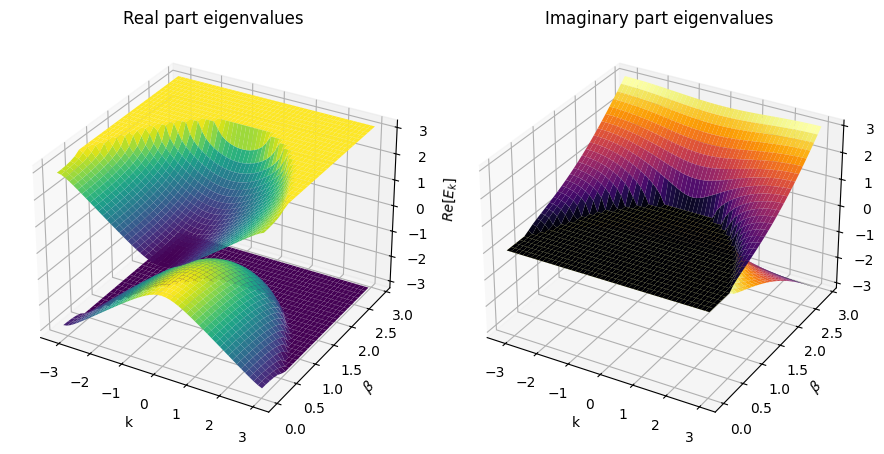

In [6]:
def E_(k_,bt_,th1,th2): 
    return np.arccos(np.cos(k_)*np.cos(th1/2)*np.cos(th2/2)-np.sin(th1/2)*np.sin(th2/2)*np.cosh(2*bt_+0j))

dim = 50
th1 = np.pi / 10
th2 = np.pi / 4
k_ = 2 * np.pi / dim * np.arange( -dim//2, dim//2 )
bta_ = np.arange(0,3,0.1)
k_,bta_ = np.meshgrid(k_,bta_)

fig = plt.figure(figsize = (11,7))
ax1 = fig.add_subplot(1,2,1,projection = "3d")
ax2 = fig.add_subplot(1,2,2,projection = "3d")

data_ = np.vectorize(E_)(k_,bta_,th1,th2)

ax1.plot_surface(k_,bta_,np.real(data_),cmap="viridis")
ax1.plot_surface(k_,bta_,-np.real(data_),cmap="viridis")

ax1.set_xlabel("k")
ax1.set_ylabel(r"$\beta$")
ax1.set_zlabel(r"$Re[E_{k}]$")
ax1.set_title("Real part eigenvalues")

ax2.plot_surface(k_,bta_,np.imag(data_),cmap="inferno")
ax2.plot_surface(k_,bta_,-np.imag(data_),cmap="inferno")

ax2.set_xlabel("k")
ax2.set_ylabel(r"$\beta$")
ax2.set_zlabel(r"$Im[E_{k}]$")
ax2.set_title("Imaginary part eigenvalues")

plt.subplots_adjust(wspace = 0.1)

plt.show()


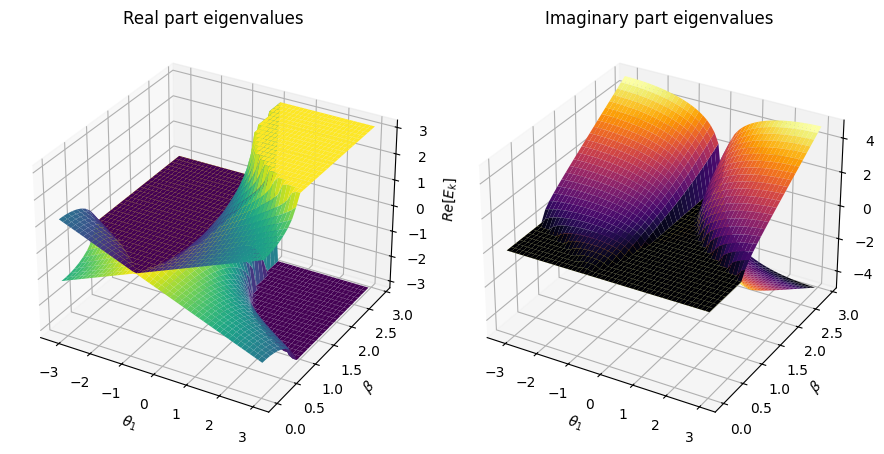

In [5]:
def E_(k_,bt_,th1,th2): 
    return np.arccos(np.cos(k_)*np.cos(th1/2)*np.cos(th2/2)-np.sin(th1/2)*np.sin(th2/2)*np.cosh(2*bt_+0j))

dim = 50
th1 = np.arange(-dim//2,dim//2)*2*np.pi/dim
th2 = np.pi / 4
k_ = 0
bta_ = np.arange(0,3,0.1)
th1,bta_ = np.meshgrid(th1,bta_)

fig = plt.figure(figsize = (11,7))
ax1 = fig.add_subplot(1,2,1,projection = "3d")
ax2 = fig.add_subplot(1,2,2,projection = "3d")

data_ = np.vectorize(E_)(k_,bta_,th1,th2)

ax1.plot_surface(th1,bta_,np.real(data_),cmap="viridis")
ax1.plot_surface(th1,bta_,-np.real(data_),cmap="viridis")

ax1.set_xlabel(r"$\theta_{1}$")
ax1.set_ylabel(r"$\beta$")
ax1.set_zlabel(r"$Re[E_{k}]$")
ax1.set_title("Real part eigenvalues")
ax1.view_init()

ax2.plot_surface(th1,bta_,np.imag(data_),cmap="inferno")
ax2.plot_surface(th1,bta_,-np.imag(data_),cmap="inferno")

ax2.set_xlabel(r"$\theta_{1}$")
ax2.set_ylabel(r"$\beta$")
ax2.set_zlabel(r"$Im[E_{k}]$")
ax2.set_title("Imaginary part eigenvalues")

plt.subplots_adjust(wspace = 0.1)

plt.show()


The gap between two bands depends on the values of $\theta_{1},\theta_{2}$. In this case it is also modulated by the value of $\beta$ parameter. So, the gap closes at: 
$$
\cosh(2\beta_{c}) = \frac{\cos{(\theta_{1}/2)}\cos{(\theta_{2}/2)}-1}{\sin{(\theta_{1}/2)}\sin{(\theta_{2}/2)}}
$$

In [7]:
beta_c = lambda th1,th2 : 1/2*np.arccosh((np.cos(th1/2)*np.cos(th2/2)-1)/(np.sin(th1/2)*np.sin(th2/2)))

Above the critical point $\beta_{c}$, the eigenspectrum is no longer purely real. 

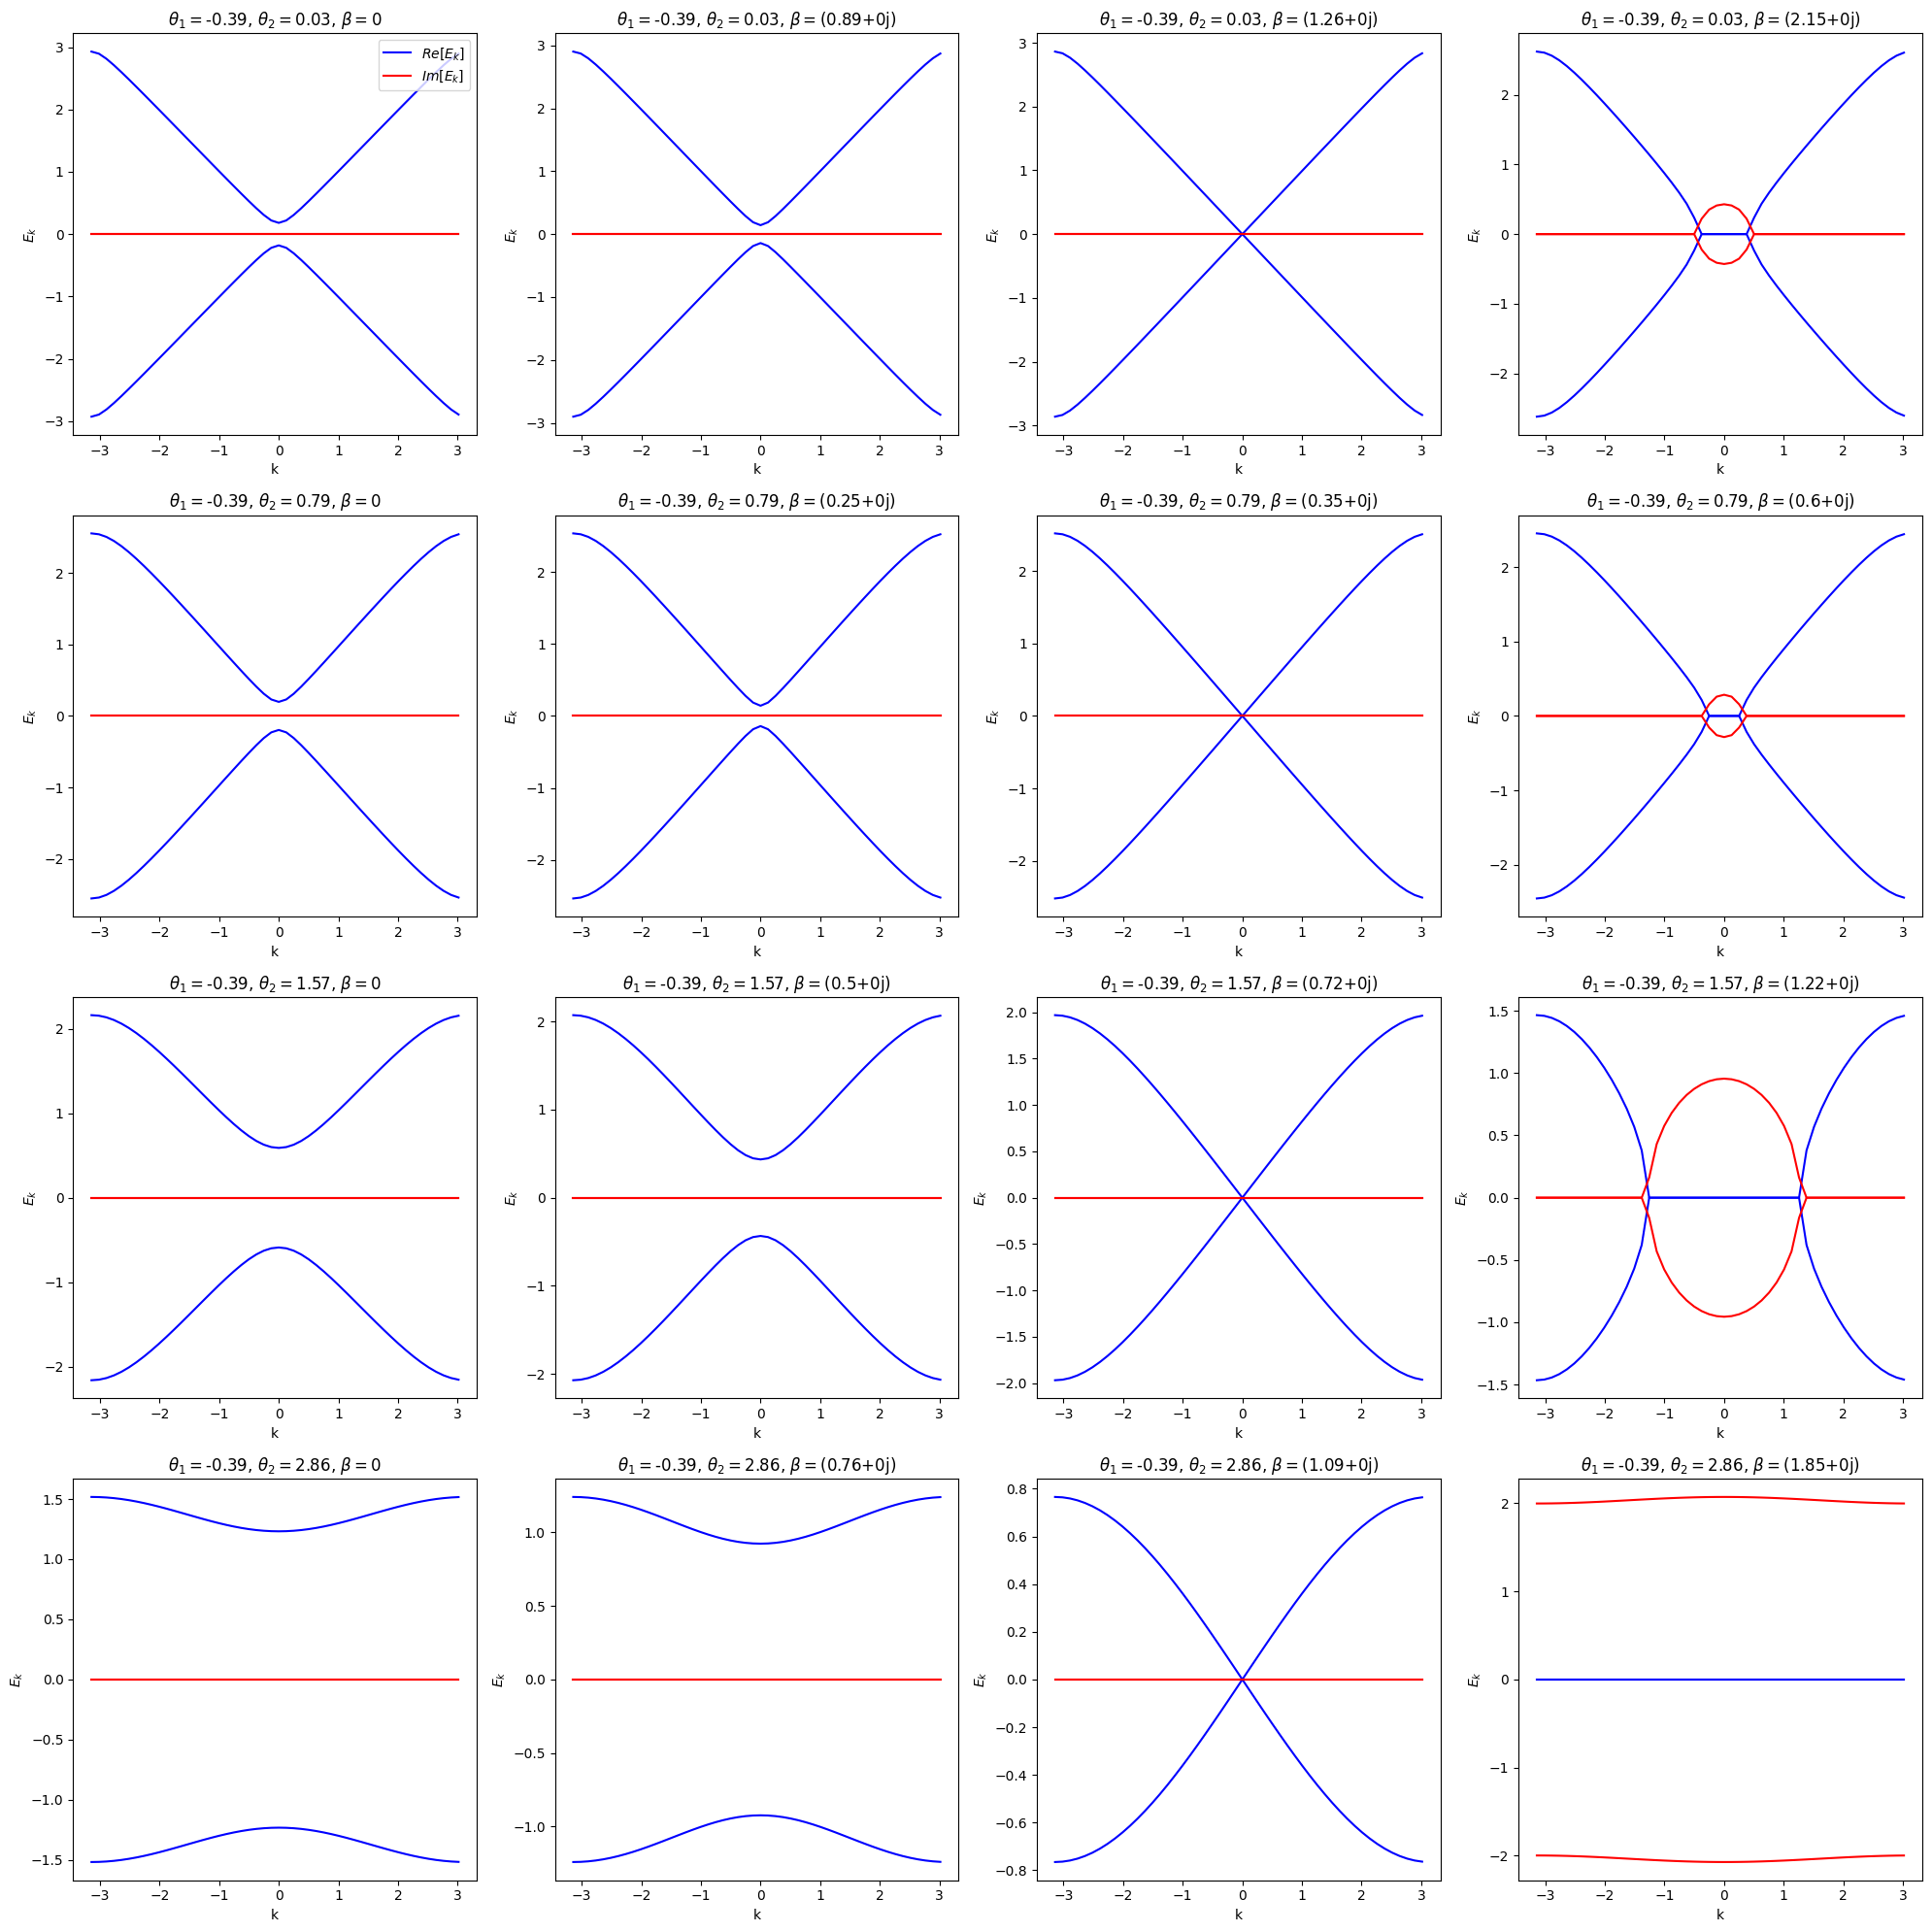

In [8]:
th1 = -np.pi/8
th2 = [np.pi/100,np.pi/4,np.pi/2,np.pi/1.1]
dim = 50
k_ = 2 * np.pi / dim * np.arange( -dim//2, dim//2 )

fig,axs = plt.subplots(4,4,figsize = (20,20))

for i in range(4):
    bc = np.arccosh((np.cos(th1/2)*np.cos(th2[i]/2)-1)/(np.sin(th1/2)*np.sin(th2[i]/2)) + 0j) / 2
    bt = [0, bc - 0.3 * bc, bc, bc + 0.7 * bc]
    
    for j in range(4):
        # Calculate energy
        Energy = E_(k_, bt[j], th1, th2[i])
        
        # Plot real and imaginary parts
        axs[i, j].plot(k_, np.real(Energy), color="blue", label=r"$Re[E_{k}]$")
        axs[i, j].plot(k_, -np.real(Energy), color="blue")
        axs[i, j].plot(k_, np.imag(Energy), color="red", label=r"$Im[E_{k}]$")
        axs[i, j].plot(k_, -np.imag(Energy), color="red")
        
        # Set title and labels
        tit = r"$\theta_{1} = $" + f'{np.round(th1, 2)}' + r", $\theta_{2} = $" + str(np.round(th2[i], 2)) + r", $\beta = $" + str(np.round(bt[j], 2))
        axs[i, j].set_title(tit)
        axs[i, j].set_xlabel("k")
        axs[i, j].set_ylabel(r"$E_{k}$")
        
        # Add legend to the first subplot only to avoid too much repetition
        if i == 0 and j == 0:
            axs[i, j].legend(loc="upper right")
        
# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

<h2>Winding number for non-unitary quanutm walk</h2>

In [9]:
def berry_phase(th1,th2,del_,dim):
    coin_dict = {
        "th1" : th1,
        "th2" : th2,
        "n" : [0,1,0],
        "del" : del_
    }
    model = nonUnitary_QW(dim,coin_dict)
    return bp.Calculate(model)

In [10]:

bp = BerryPhase()
th_1 = np.arange(-2*np.pi,2*np.pi,0.1)
th_2 = np.arange(-2*np.pi,2*np.pi,0.1)
del_t = np.linspace(0,2,9)
th_1, th_2, del_t = np.meshgrid(th_1,th_2,del_t)

data_ans = np.vectorize(berry_phase)(th_1,th_2,del_t,10)

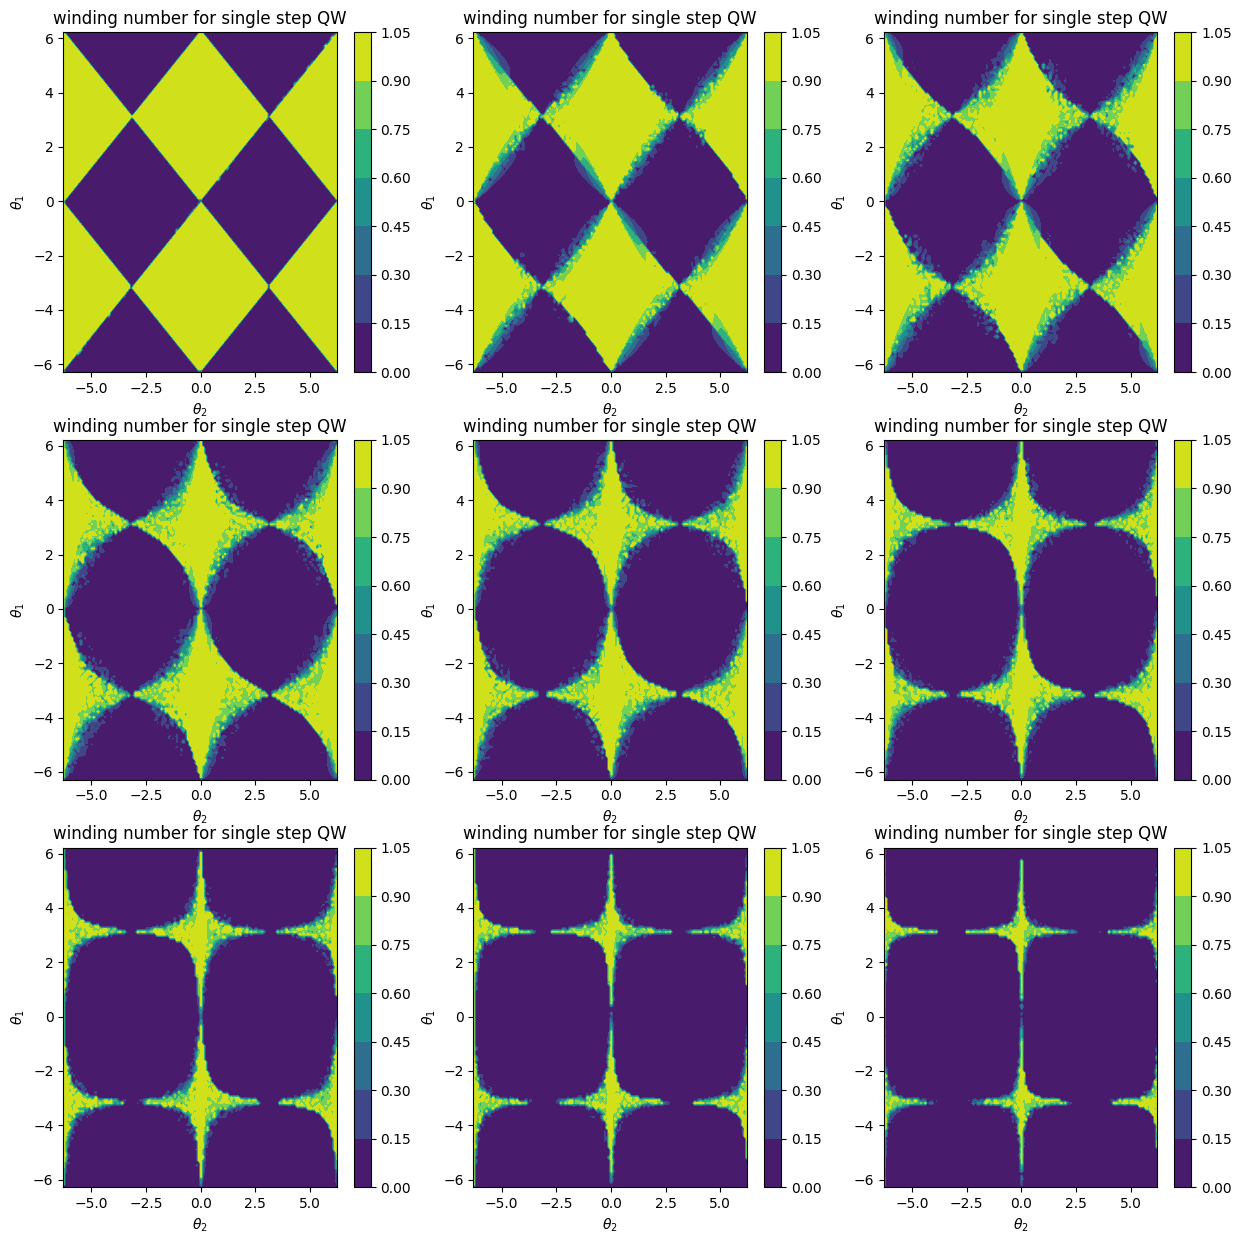

In [11]:
fig,ax = plt.subplots(3,3,figsize = (15,15))

for i in range(3):
    for j in range(3):
        cax = ax[i,j].contourf(th_1[:,:,0],th_2[:,:,0],data_ans[0][:,:,i*3+j]/np.pi,cmap = "viridis")
        fig.colorbar(cax)
        ax[i,j].set_xlabel(r"$\theta_{2}$")
        ax[i,j].set_ylabel(r"$\theta_{1}$")
        ax[i,j].set_title("winding number for single step QW")

plt.show()

In [12]:
dim = 201
coin_dict = {"th1" : 5*pi/8, "th2" :-3*pi/8. , "n" : [0,1,0] ,"del"  : 0.25}

model = nonUnitary_QW(dim,coin_dict)
bp = BerryPhase()
ns = np.real(bp.vector_representation(model))

th_1 = np.arange(-2*np.pi,2*np.pi,0.1)
th_2 = np.arange(-2*np.pi,2*np.pi,0.1)
th_1, th_2= np.meshgrid(th_1,th_2)
data_ans = np.vectorize(berry_phase)(th_1,th_2,coin_dict['del'],10)

th1 = coin_dict["th1"]
th2 = coin_dict["th2"]



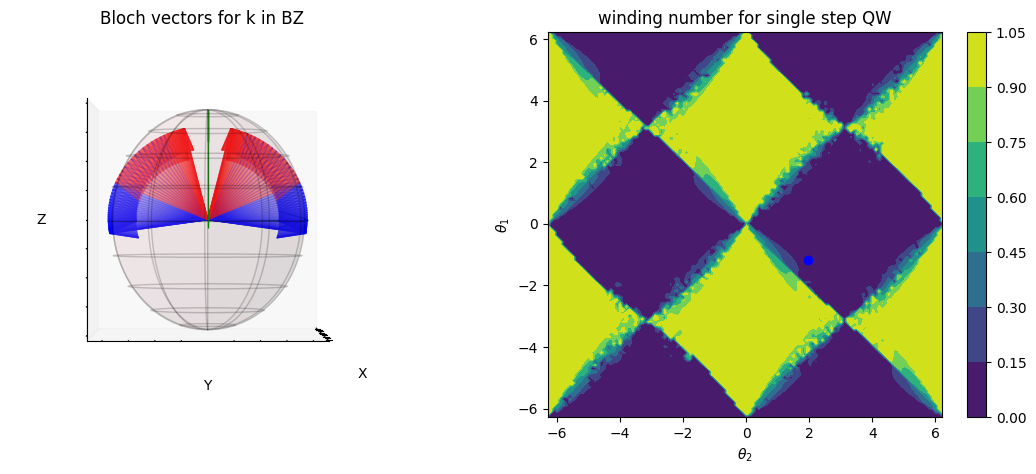

In [13]:
ax1,ax2 = berry_bloch_phase(th1,th2,ns,th_1,th_2,data_ans[0])
ax1.view_init(elev=0, azim=0)

In [14]:
dim = 201
coin_dict = {"th1" : pi/8, "th2" :-3*pi/8. , "n" : [0,1,0] ,"del"  : 1.8}

model = nonUnitary_QW(dim,coin_dict)
bp = BerryPhase()
ns = np.real(bp.vector_representation(model))

th_1 = np.arange(-2*np.pi,2*np.pi,0.1)
th_2 = np.arange(-2*np.pi,2*np.pi,0.1)
th_1, th_2= np.meshgrid(th_1,th_2)
data_ans = np.vectorize(berry_phase)(th_1,th_2,coin_dict['del'],10)

th1 = coin_dict["th1"]
th2 = coin_dict["th2"]

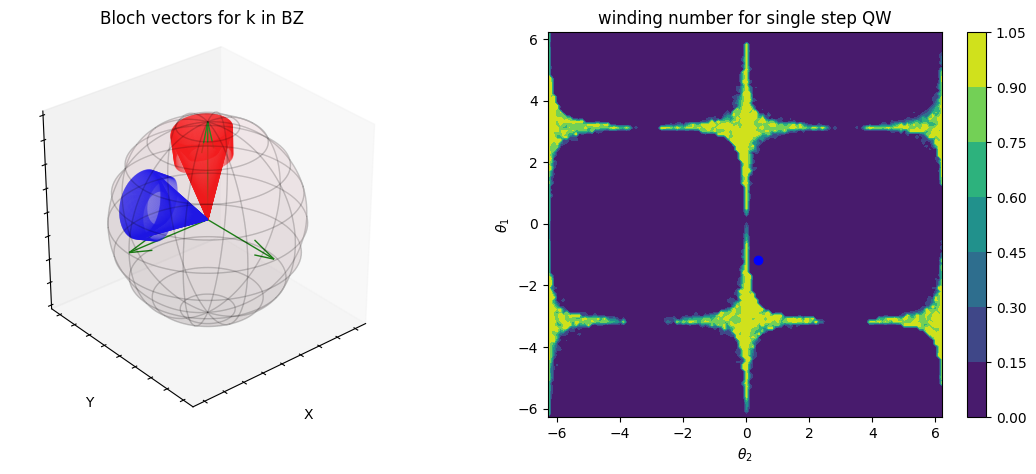

In [15]:
ax1,ax2 = berry_bloch_phase(th1,th2,ns,th_1,th_2,data_ans[0])
ax1.view_init(elev=30, azim=50)

In [16]:
dim = 201
coin_dict = {"th1" : pi/8, "th2" :-3*pi/8. , "n" : [0,1,0] ,"del"  : 3}

model = nonUnitary_QW(dim,coin_dict)
bp = BerryPhase()
ns = np.real(bp.vector_representation(model))

th_1 = np.arange(-2*np.pi,2*np.pi,0.1)
th_2 = np.arange(-2*np.pi,2*np.pi,0.1)
th_1, th_2= np.meshgrid(th_1,th_2)
data_ans = np.vectorize(berry_phase)(th_1,th_2,coin_dict['del'],10)

th1 = coin_dict["th1"]
th2 = coin_dict["th2"]

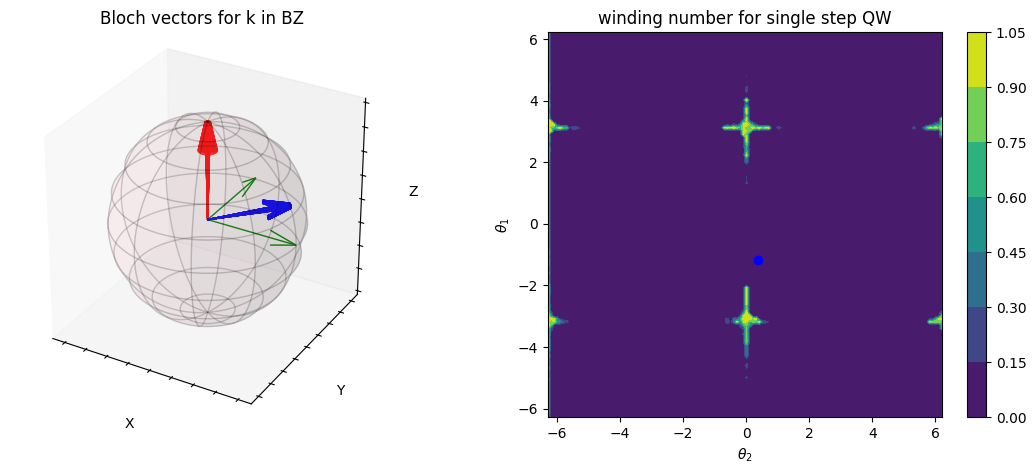

In [17]:
ax1,ax2 = berry_bloch_phase(th1,th2,ns,th_1,th_2,data_ans[0])

<h1>Sources</h1>

[1] https://www.nature.com/articles/s41598-021-89441-8